# DistilBERT 加逻辑回归分类

数据解介绍：
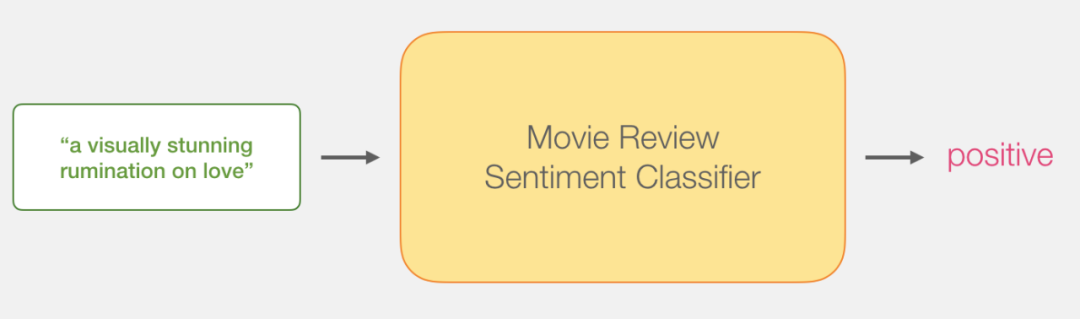


DistilBERT处理这个句子，并将从中提取的一些信息传递给下一个模型。DistilBERT 是 BERT 的小版本，由HuggingFace的团队开发并开源。它是 BERT 的一个更轻、更快的版本，与它的性能大致相当。

下一个模型是来自 scikit-learn 的一个基本逻辑回归模型，它将接受 DistilBERT 处理的结果，并将句子分为正样本或负样本(分别为 1 和 0)。
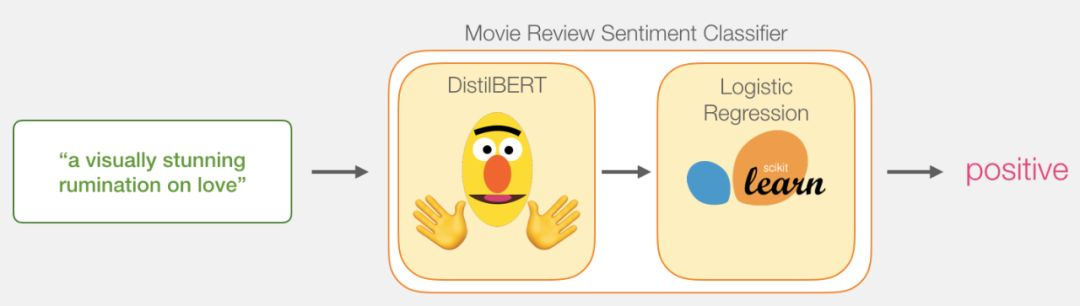

1. 概要

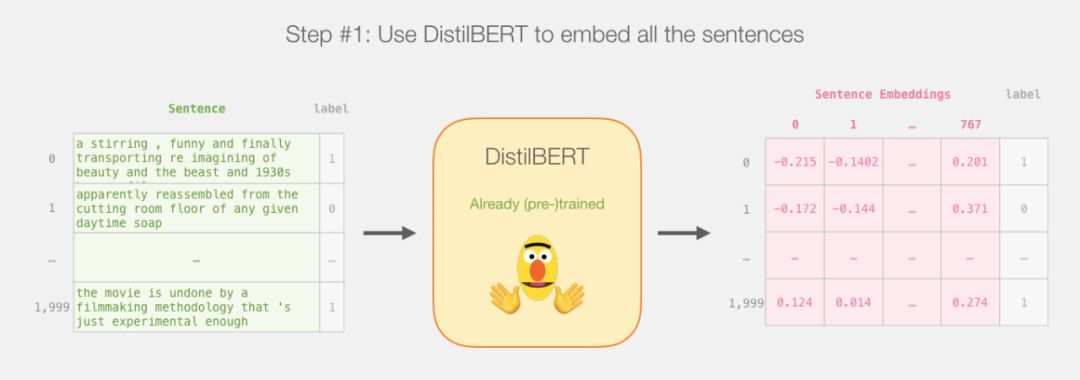

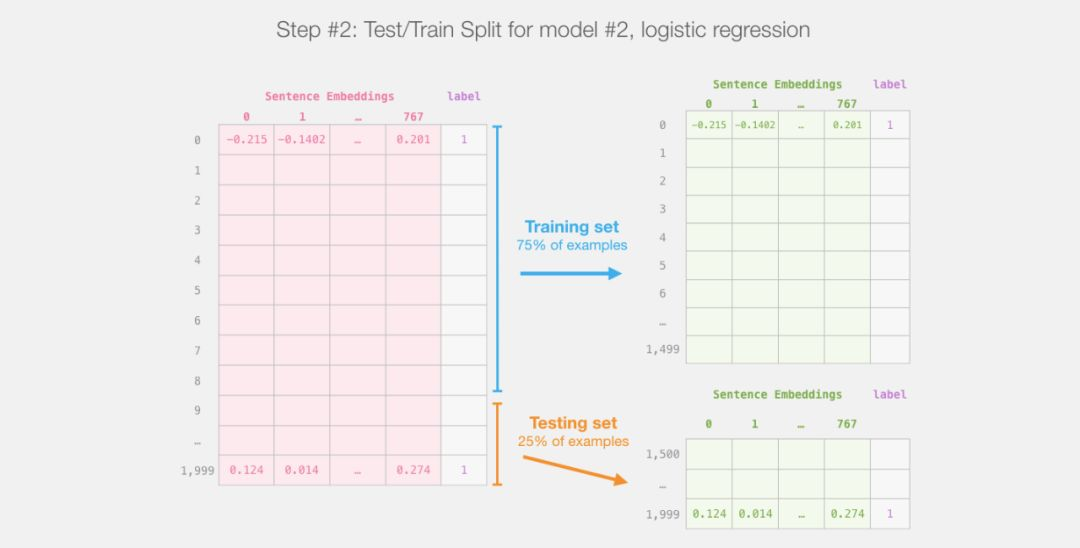 

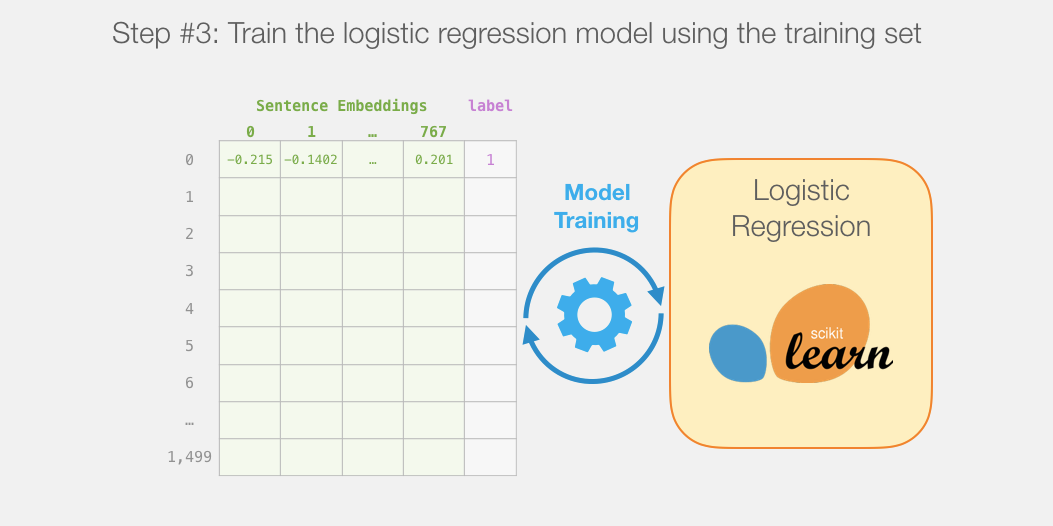

具体的实现步骤：
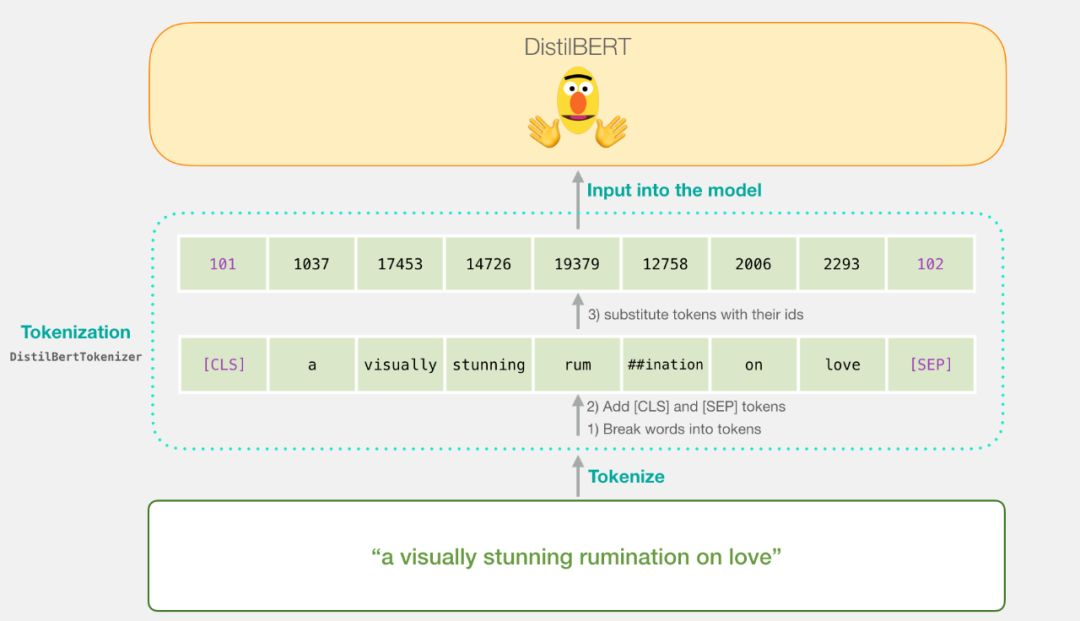

上半部分的数据；

通过 DistilBERT 传递输入向量的工作方式与 BERT 一样。输出将是每个输入 token 的向量。每个向量由 768 个数字(浮点数)组成。

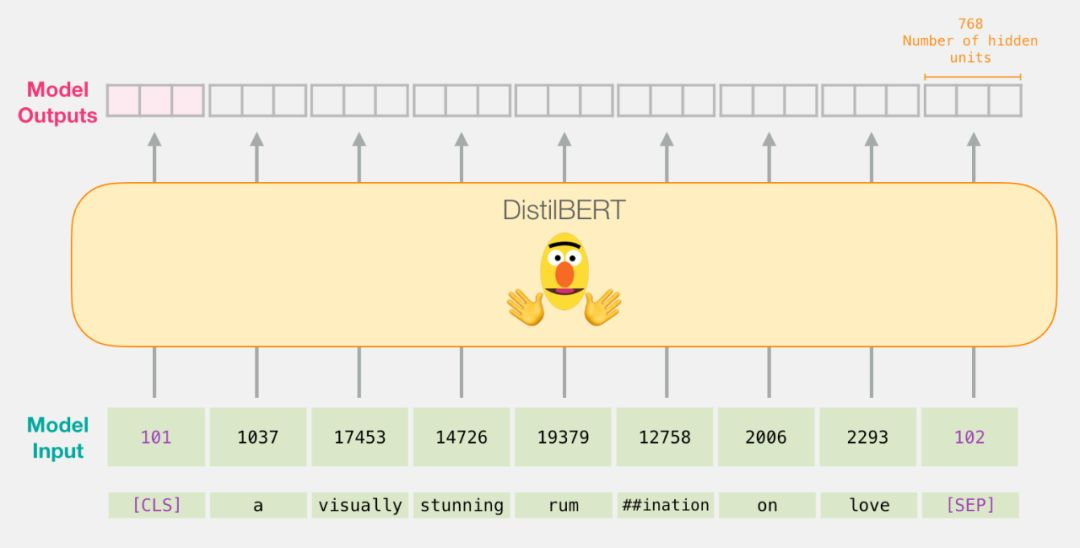

因为这是一个句子分类任务，所以除了第一个向量(与[CLS]token 相关联的向量)外，我们忽略了所有其他向量。我们传递的这个向量作为逻辑回归模型的输入。

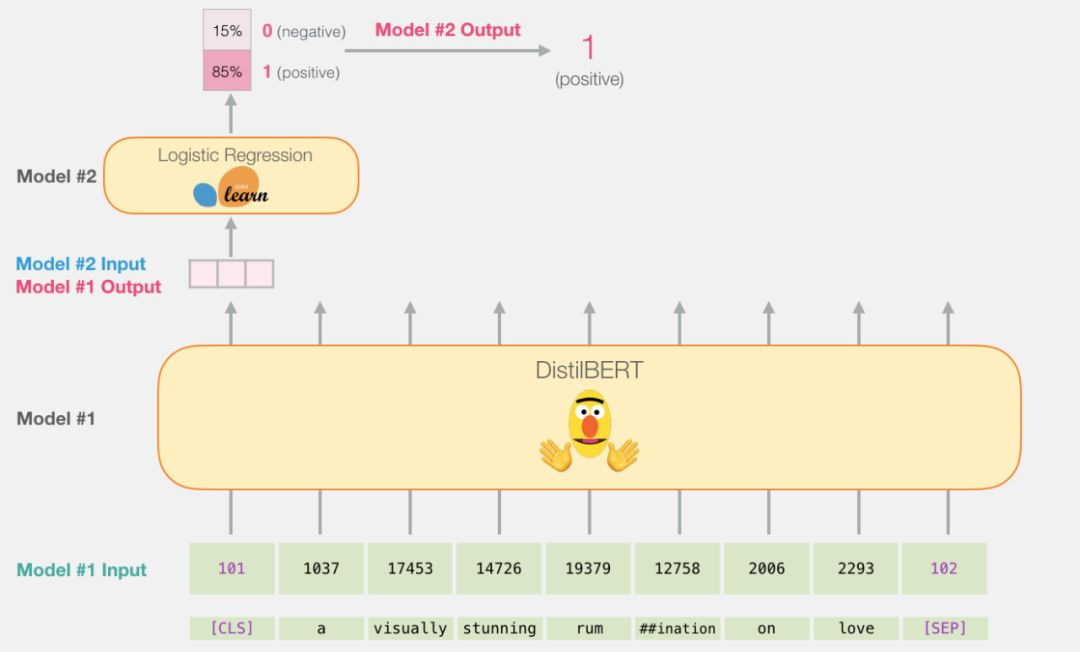

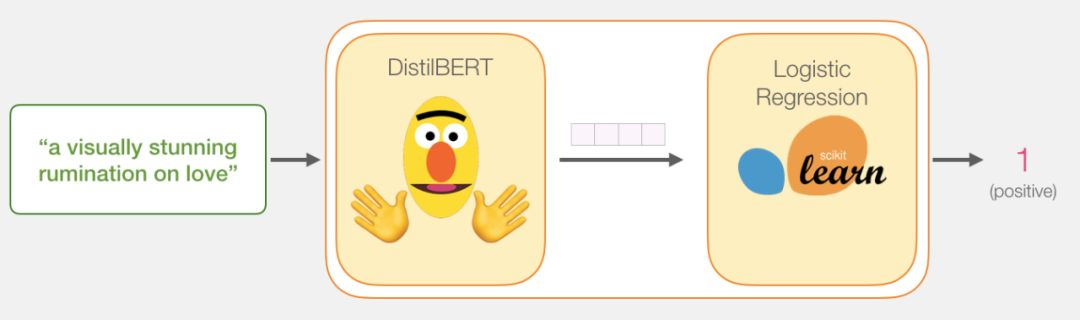

### 导包 

In [1]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 

In [2]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [22]:
df= df[:2000]

In [24]:
df

,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1
...,...,...
1995,too bland and fustily tasteful to be truly pru...,0
1996,it does n't work as either,0
1997,this one aims for the toilet and scores a dire...,0
1998,in the name of an allegedly inspiring and easi...,0


In [25]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [26]:
tokenized = df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [27]:
tokenized.head()

0    [101, 1037, 18385, 1010, 6057, 1998, 2633, 182...
1    [101, 4593, 2128, 27241, 23931, 2013, 1996, 62...
2    [101, 2027, 3653, 23545, 2037, 4378, 24185, 10...
3    [101, 2023, 2003, 1037, 17453, 14726, 19379, 1...
4    [101, 5655, 6262, 1005, 1055, 12075, 2571, 376...
Name: 0, dtype: object

In [28]:
type(tokenized)

pandas.core.series.Series


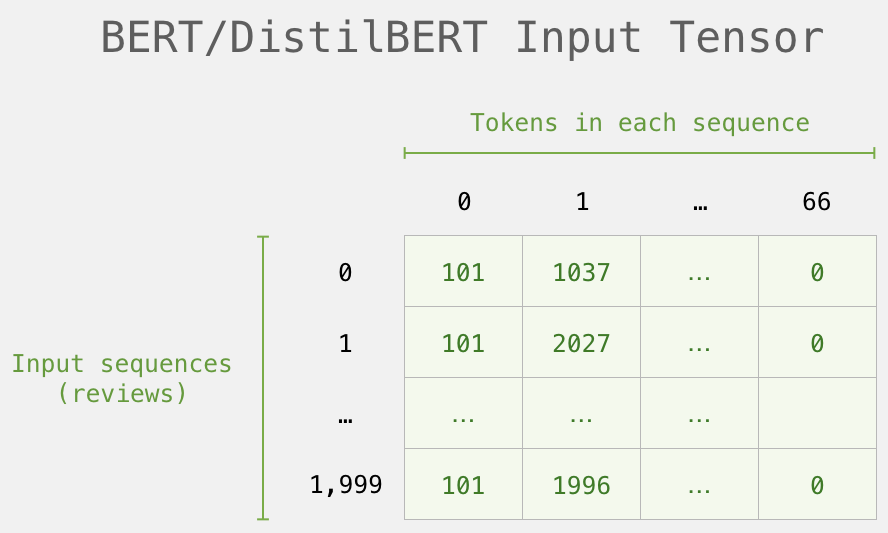

In [29]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [30]:
input_ids = torch.tensor(np.array(padded))

with torch.no_grad():
    last_hidden_states = model(input_ids)

last_hidden_states保存 DistilBERT 的输出。在我们的例子中，这是个形状为（2000,66,768）的 tuple。2000(因为我们只局限于 2000 个例子)，66(这是 2000 个例子中最长序列中的标记数)，768(在 DistilBERT 模型中隐藏单元的数量)。

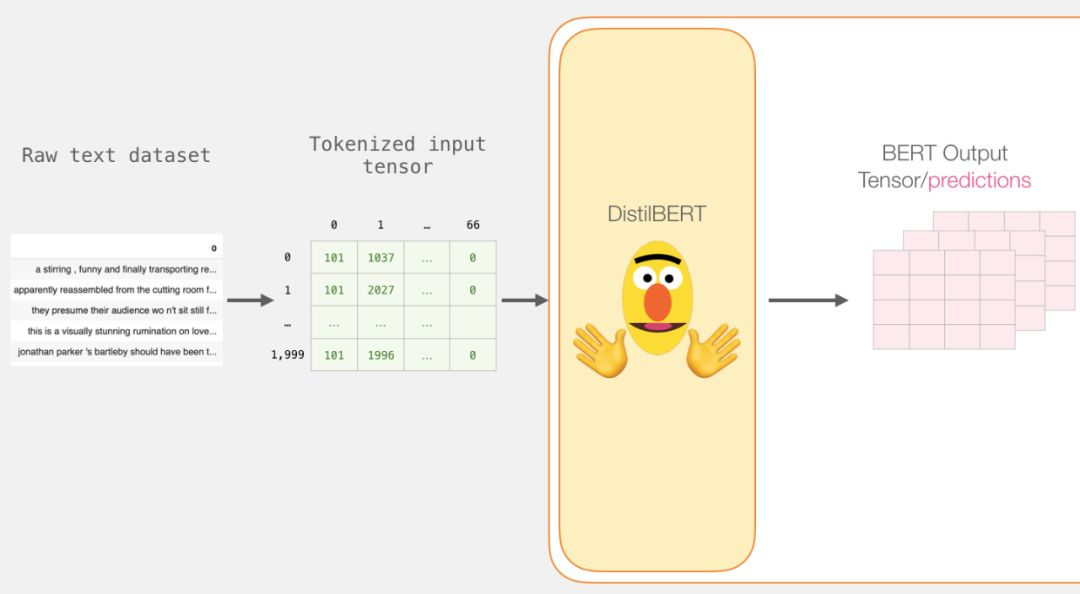

观察一下三三维的输出

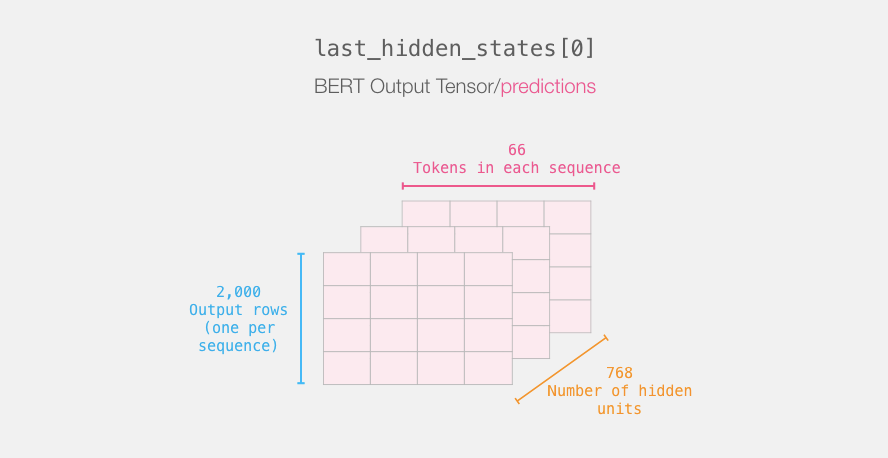

针对上图：

一共有768张纸  每张纸上都写满了数字

一张纸中：

每行的66列是66个词

本次投入的是2000个句子，也就是2000行

**这就能理解了输出的三个维度的实际含义**

输入的每一行都与数据集中的每一个句子相关联
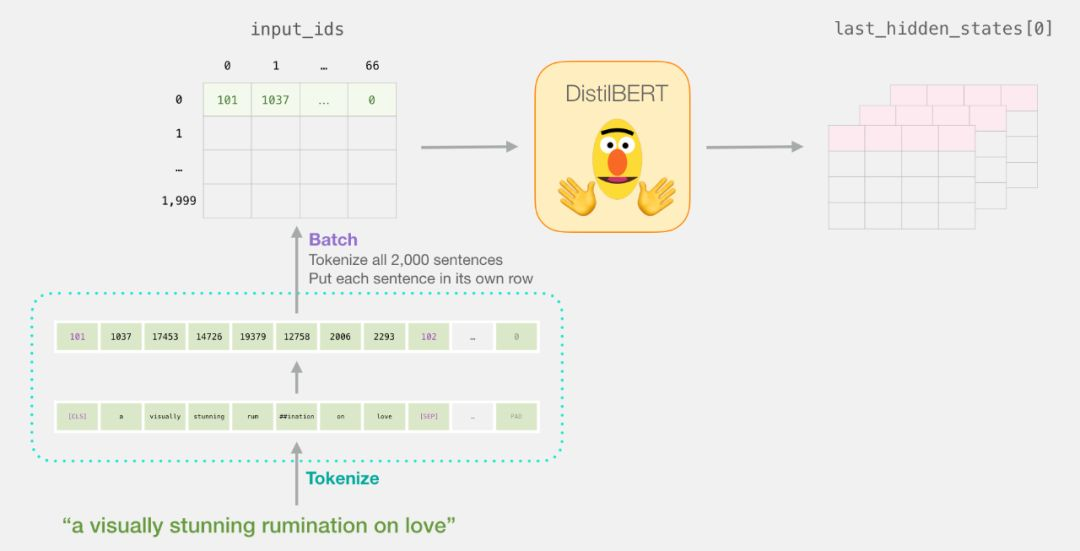

### 重点：）

句子分类我们对CLS这个token感兴趣
因此我们只对上面的立方体进行切片

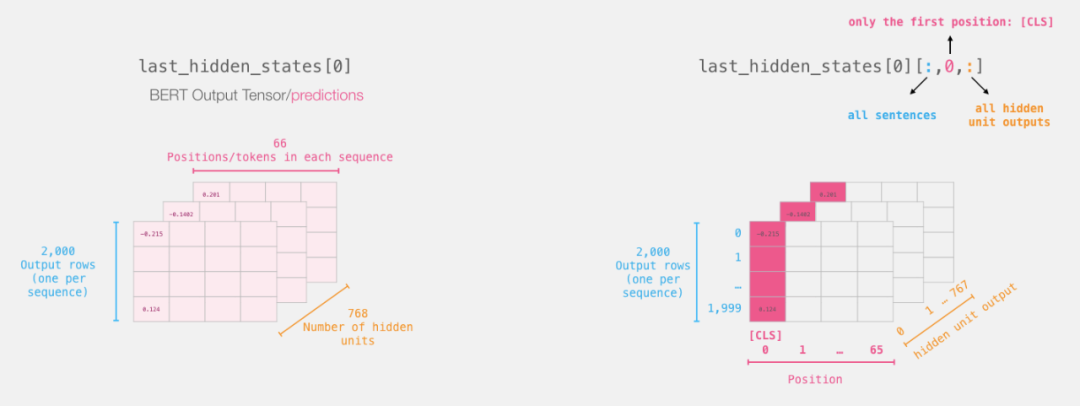

这点的切片，参照之前的解读
https://github.com/hodge-ge/Lab_task/blob/Build-pytorch-model-and-increase-the-difficulty-step-by-step/pytorch_problem.md

上图的解释：
<font color=red>针对**[ 句子数目，每个句子的token表达，隐藏层单元输出的个数]**</font>


我们取出**[::,0,::]**


<font face="黑体">**所有句子,所有句子的第0个位置token表达,隐藏层单元的所有输出**</font>




In [31]:
last_hidden_states[0].shape

torch.Size([2000, 59, 768])

In [36]:
 # Slice the output for the first position for all the sequences, take all hidden unit outputs
features = last_hidden_states[0][:,0,:].numpy()

labels = df[1]

In [33]:
features.shape

(2000, 768)

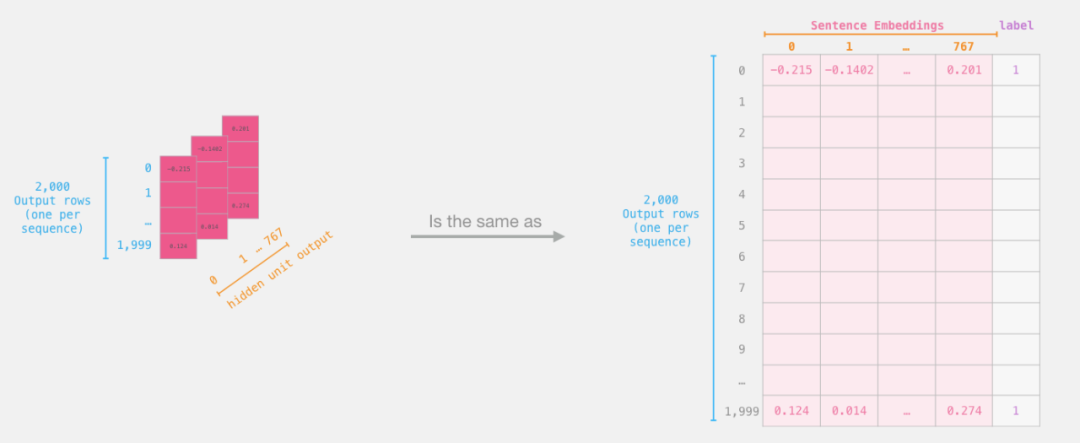

逻辑回归的输入
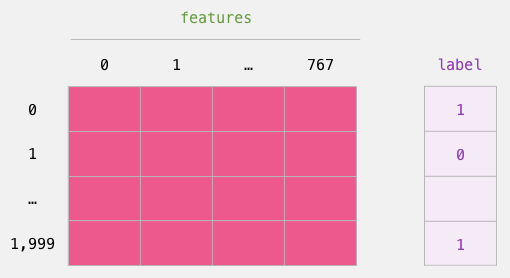
我们用来训练逻辑回归的数据集。这些特征是我们在前面的图中分割的[CLS]token(位置#0)的BERT的输出向量。每一行对应数据集中的一个句子，每一列对应Bert/DistilBERT模型顶层transformer block的前馈神经网络的一个隐藏单元的输出

划分数据集

In [37]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

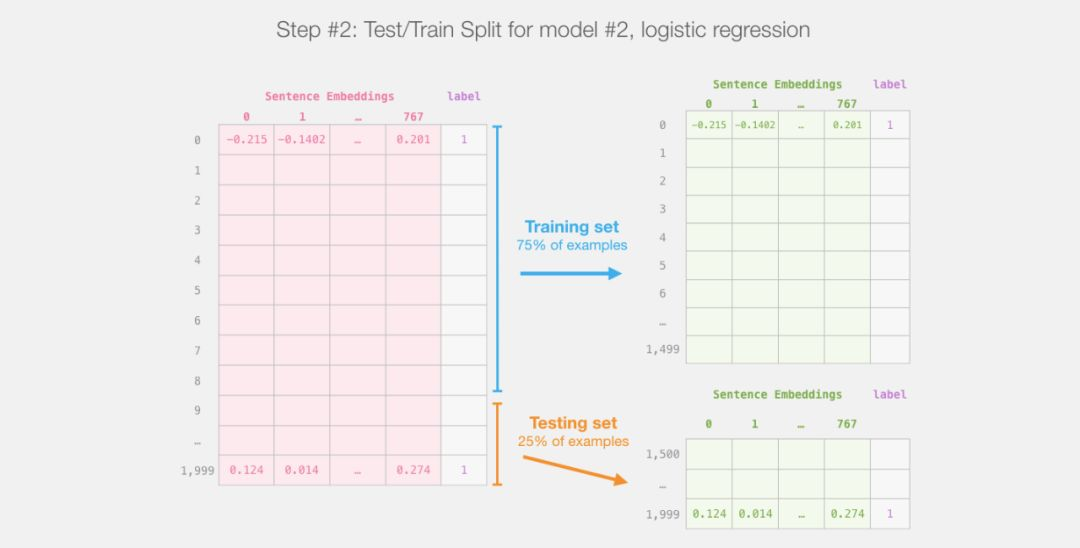

In [40]:
from sklearn.model_selection import GridSearchCV
parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(train_features, train_labels)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Sp

best parameters:  {'C': 5.263252631578947}
best scrores:  0.8053333333333333


In [42]:
lr_clf = LogisticRegression(C= 5.2632526315789)
lr_clf.fit(train_features, train_labels)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=5.2632526315789, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
lr_clf.score(test_features, test_labels)

0.81

作为参考，这个数据集的最高准确率分数是96.8。DistilBERT 可以通过训练来提高它在这个任务中的分数 —— 这个过程称为 finetune，它更新 BERT 的权重，使它在句子分类中获得更好的性能(我们可以称之为“下游任务”)。finetune 后的馏分达到了90.7的准确率分数。全尺寸的 BERT 模型可以达到94.9。



由word2vec、ELMo、OpenAI GPT、BERT得到词向量的方式，就对应了第2小节中的方式b。这四种方法得到词向量的流程大概是这样的：

a、 准备大量的单语语料(不用带任何标签)；
b、 设计一个神经网络；
c、 用大量的单语语料无监督的训练这个神经网络；

        当这个神经网络训练好后，就会得到一种副产品：
 ** 权重矩阵，这个权重矩阵中的向量就是对应词的词向量 **        

一个神经网络会得到几个这种权重矩阵和网络的设计和层数有关，比如word2vec(CBOW，Skip-Gram)会得到一个权重矩阵，BERT-Base有12层会得到12+1=13个权重矩阵（one-hot后面的全连接层也算一个）。